# Hyper-parameter tuning part 1:
## Classifying 20 newsgroup data

Created by John Burt

Based on example code [from Scikit-learn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py) 

In this example, I implement a classifier to estimate whether a comment is from one of two selected newsgroups, "alt.atheism" or "talk.religion.misc".

General classifier procedure:
, vectorize the text content into features using TfidfVectorizer
, train a stochastic gradient descent classifier (SGDClassifier) to classify text as one of the given newsgroup categories.

Hyperparameter tuning procedure:
, Use a hyper parameter grid search to find the SGDClassifier parameters that give best accuracy.


### About the 20 Newsgroups text dataset:
The [20 newsgroups dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups) is easily accessible from the scikit-learn module. It comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

The 20 newsgroup names are:
- alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc


In [26]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

# set matplotlib environment and import some basics
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100 # set to -1 to see entire text

# import the scikit modules to be used
from sklearn.datasets import fetch_20newsgroups

# specify some categories from the training set
categories = [
    'alt.atheism',
    'talk.religion.misc',
]
# Uncomment the following to do the analysis on all the categories
#categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

# load the training dataset
data = fetch_20newsgroups(subset='train', categories=categories)

print("\n%d total samples"%(len(data.target)))
for catname,index in zip(data.target_names, range(len(data.target_names))):
    print("  %d samples of %s"%(sum(data.target==index), catname))


Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']

857 total samples
  480 samples of alt.atheism
  377 samples of talk.religion.misc


In [27]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Tfidf vectorizer: vectorize the comment texts, and apply TF-IDF weighting
# Note that there are a bunch of parameter options, but I just use defaults here.
print("\nVectorizing text data...")
X_vectors = TfidfVectorizer().fit_transform(data.data)
print("X_vectors.shape = ",X_vectors.shape)

# Tfidf vectorizer:
# define defaults: doing it this way allows us to define our own default params
clf_defaults = {
    "alpha": 1e-03, 
    "penalty" : 'l2',
    "n_iter" : 10
    }

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    #'alpha': (1e-02, 1e-03, 1e-04, 1e-05, 1e-06),
    'penalty': ( 'none', 'l2', 'l1', 'elasticnet'),
    'n_iter': (5, 10, 20, 50, 80),
}

# create the classifier to use and set the defaults
clf = SGDClassifier(**clf_defaults)

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(clf, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("parameters:")
print(parameters)
t0 = time()
grid_search.fit(X_vectors, data.target)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))



Vectorizing text data...
X_vectors.shape =  (857, 18089)
Performing grid search...
parameters:
{'n_iter': (5, 10, 20, 50, 80), 'penalty': ('none', 'l2', 'l1', 'elasticnet')}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    2.0s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.1s finished


done in 2.482s

Best score: 0.943
Best parameters set:
	n_iter: 80
	penalty: 'l2'


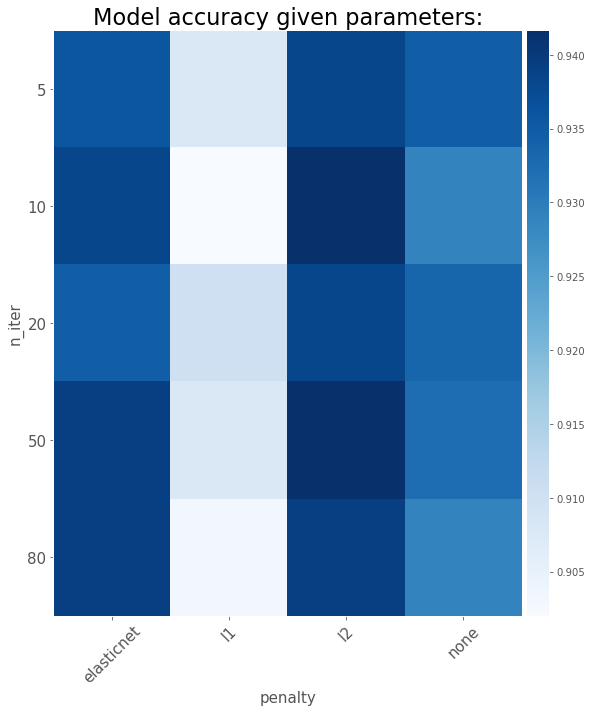

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# display the results of each parameter set as a confusion matrix grid
# NOTE: this only shows the first two parameters
results = pd.DataFrame(grid_search.cv_results_)

# names of tuned parameters
paramnames = list(parameters.keys())

# convert the gridsearch score output into an array of param 1 vs param 2
resultspv = results.pivot(index='param_'+paramnames[0], columns='param_'+paramnames[1], values='mean_test_score')

# plot a grid of the data
fsize = 15
a = plt.figure(figsize=(10,10))
plt.rcParams["axes.grid"] = False
ax = plt.gca()
im = ax.imshow(resultspv.values, cmap=plt.cm.Blues)
#ax.colorbar(im)
plt.title("Model accuracy given parameters:", fontsize = fsize*1.5)
plt.xticks(np.arange(resultspv.shape[1]), resultspv.columns, rotation=45, fontsize = fsize)
plt.yticks(np.arange(resultspv.shape[0]), resultspv.index, fontsize = fsize)
plt.xlabel(paramnames[1], fontsize = fsize)
plt.ylabel(paramnames[0], fontsize = fsize)
plt.tight_layout()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

a = plt.colorbar(im, cax=cax)
